<div style="border-radius:10px;border:#2E86C1 solid;padding:15px;background-color:#2874A6;font-size:110%;text-align:left">
<a id=toc></a>
<h1 style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-size: 100% auto;background-position: 0px 0px; 
"><span style='color:white'><b> Probability Calibration For Machine Learning in Python</b></span></h1>


# Introduction
#### In machine learning classification tasks, the conventional approach involves predicting class values directly, such as determining whether an observation belongs to class 0 or class 1 in binary classification. However, a more nuanced approach involves predicting the probability of an observation belonging to each class. For instance, if a model assigns a probability of 0.85 (85%) to class 1 and 0.15 (15%) to class 2, it offers a clearer indication of the model’s confidence in the prediction. Nevertheless, not all models excel in accurately predicting calibrated probabilities that closely align with the expected distribution for each class. In such scenarios, the options are typically limited to either relying solely on the class predicted by a model, disregarding the associated probabilities, or opting for a different model that provides class probabilities.

#### Is there a middle ground where we can leverage the strengths of our original model while still obtaining probabilities for enhanced interpretation? Indeed, there is. This middle path involves probability calibration, a technique that fine-tunes the predicted probabilities from our existing model, allowing us to maintain its benefits while improving the interpretability of the predictions. We’ll explore this approach in detail in the next section.

# What is probability calibration?
#### Probability calibration in machine learning enhances prediction accuracy by aligning predicted probabilities with true likelihoods. Unlike traditional models that assign class labels, calibration estimates the probability of an observation belonging to each class, offering deeper insights into prediction confidence. By adjusting predicted probabilities to match the actual distribution, calibration improves model reliability. It provides a middle ground where users can leverage original models while obtaining calibrated probabilities for enhanced interpretation. With calibrated probabilities, users gain clarity on prediction uncertainties, facilitating more precise decision-making across various machine learning applications.

# Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier# Step 3: Train logistic regression model
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Data loading & processing

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')


print(f'Shape of train data: {df_train.shape}')
print(f'Shape of test data: {df_test.shape}')


SEED = 12
n_trials = 2
target = 'Exited'

df_train = df_train.drop(['id', 'Surname'], axis = 1)
df_test = df_test.drop(['id', 'Surname'], axis = 1)


features = df_train.columns.drop(target)
CAT_FEATS = df_train.select_dtypes(include='object').columns
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != target and x in features]

assert target not in features
assert target not in CAT_FEATS
assert target not in NUM_FEATS


# Encode all the categorical features
df_train_cat_encode = df_train[CAT_FEATS]
df_test_cat_encode= df_test[CAT_FEATS]

# Dummify the train and test data
df_train_cat_encoded = pd.get_dummies(df_train_cat_encode, columns = CAT_FEATS, drop_first=True)
df_test_cat_encoded = pd.get_dummies(df_test_cat_encode, columns = CAT_FEATS, drop_first=True)


# Scale all the numerical features
df_train_num_scale = df_train[NUM_FEATS]
df_test_num_scale = df_test[NUM_FEATS]

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(df_train_num_scale)

# Scale the training data
df_train_num_scaled = minmax_scaler.transform(df_train_num_scale)
df_train_num_scaled = pd.DataFrame(df_train_num_scaled, columns=df_train_num_scale.columns)

# Scale the test data using the parameters from the training data
df_test_num_scaled = minmax_scaler.transform(df_test_num_scale)
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=df_test_num_scale.columns)


# Concatenate datasets
df_train_combined = pd.concat([df_train_cat_encoded.reset_index(drop=True), df_train_num_scaled.reset_index(drop=True)], axis=1)

# Concatenate test datasets
df_test_combined = pd.concat([df_test_cat_encoded.reset_index(drop=True), df_test_num_scaled.reset_index(drop=True)], axis=1)


df_train_combined['Exited'] = df_train['Exited']

df_train_combined = df_train_combined.head(10000)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_train_combined.drop(columns=[target])
y = df_train_combined[target]

Shape of train data: (165034, 14)
Shape of test data: (110023, 13)


# Use case 1: Fetching class probabilities

#### In this case, we build a SVC model for the binary classification with the below listed steps.

* Split the dataset into train, test and validation set
* Build a SVC model and make prediction
* Measure the model results.

In [3]:
# Split dataset into train and test sets (80% train and validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train and validation sets (60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Step 3: Train SVC model
svc = SVC()  
svc.fit(X_train, y_train)

# Step 4: Evaluate model before calibration on validation set
y_pred_val = svc.predict(X_val)

# print("Accuracy before calibration (validation set):", accuracy_score(y_val, y_pred_val))
# print("Classification Report before calibration (validation set):")
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1574
           1       0.75      0.28      0.40       426

    accuracy                           0.83      2000
   macro avg       0.79      0.63      0.65      2000
weighted avg       0.81      0.83      0.79      2000



#### We get the predicted class as [0] which is fine but we don’t know how confident the model is with this prediction meaning we don’t have the predicted probabilities for each class. To fetch these probabilities in most models we use predict_proba() function on the same record. We would get an error in this case.

In [4]:
print(svc.predict_proba(X_val.loc[[1]]))

AttributeError: predict_proba is not available when  probability=False

In [6]:
print(svc.predict(X_val.loc[[1]]))

[0]


#### Well, there are some models that only output the predicted class and don’t show the probabilities meaning they don’t have predict_proba() function. In case of SVC, we can still set the probability = True and get these probabilities but may be not in many other models.

In [11]:
svc = SVC(probability=True)  
svc.fit(X_train, y_train)
y_pred_val = svc.predict(X_val)
print(svc.predict_proba(X_val.loc[[1]]))


[[0.88231833 0.11768167]]


#### Let’s say we have a working model that doesn’t give us the class probabilities. In such a scenario, we can leverage probability calibration and explained below.

* CalibratedClassifierCV: A scikit-learn class that performs probability calibration for classifiers.
* svc: The original classifier (in this case, a Support Vector Classifier or SVC) that we want to calibrate.
* method=’isotonic’: Specifies the method used for probability calibration. In this case, ‘isotonic’ refers to isotonic regression, a non-parametric method for calibration.
* cv=’prefit’: Indicates that to use the already trained model (svc) without further training.

In [12]:
calibrated_svc = CalibratedClassifierCV(svc, method='isotonic', cv='prefit')
calibrated_svc.fit(X_val, y_val)

CalibratedClassifierCV(cv='prefit', estimator=SVC(probability=True),
                       method='isotonic')

In [13]:
print(calibrated_svc.predict(X_val.loc[[1]]))

[0]


In [14]:
print(calibrated_svc.predict_proba(X_val.loc[[1]]))

[[0.92592593 0.07407407]]


### Key observations
* The prediction from original model and the calibrated model is [0]
* The probabilities are different in both cases, because the underlying methodology is different and values are not significantly different.
* We have been able to take a model that doesn’t output the class probabilities and created a wrapper on it via calibrated model to get the class probabilties.

# Use case 2: Improving model performance
#### Let’s extend the same model and learn how to incrementally improve the model’s performance. There are two methods to configure the calibration model — Sigmoid and Isotonic. We will implement both these methods and compare it with uncalibrated model.

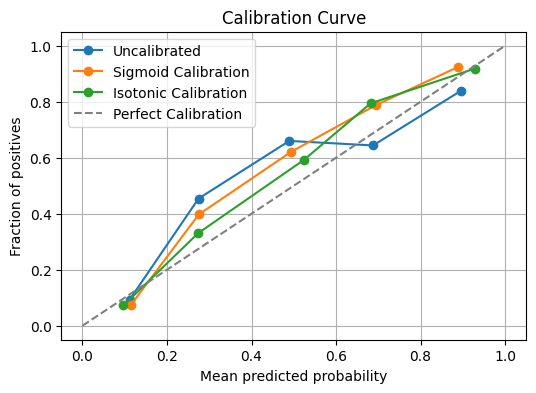

In [15]:
n_bins = 5
# Split dataset into train and test sets (80% train and validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train and validation sets (60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Train SVC model
svc = SVC(probability=True)  # Set probability=True for SVC to enable probability estimates
svc.fit(X_train, y_train)

# Evaluate model before calibration on validation set
y_pred_val = svc.predict(X_val)
prob_pos_val = svc.predict_proba(X_val)[:, 1]

# Generate uncalibrated calibration curve data
prob_true_uncalibrated, prob_pred_uncalibrated = calibration_curve(y_val, prob_pos_val, n_bins=n_bins)

# Calibrate model's predicted probabilities using sigmoid method on validation set
calibrated_svc_sigmoid = CalibratedClassifierCV(svc, method='sigmoid', cv= 5)
calibrated_svc_sigmoid.fit(X_val, y_val)
prob_pos_val_sigmoid = calibrated_svc_sigmoid.predict_proba(X_val)[:, 1]

# Calibrate model's predicted probabilities using isotonic method on validation set
calibrated_svc_isotonic = CalibratedClassifierCV(svc, method='isotonic', cv=5)
calibrated_svc_isotonic.fit(X_val, y_val)
prob_pos_val_isotonic = calibrated_svc_isotonic.predict_proba(X_val)[:, 1]

# Generate calibration curve data for sigmoid calibration
prob_true_sigmoid, prob_pred_sigmoid = calibration_curve(y_val, prob_pos_val_sigmoid, n_bins=n_bins)

# Generate calibration curve data for isotonic calibration
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_val, prob_pos_val_isotonic, n_bins=n_bins)

# Plot calibration curves
plt.figure(figsize=(6, 4))

# Plot uncalibrated calibration curve
plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='o', label='Uncalibrated')
# Plot calibration curve for sigmoid calibration
plt.plot(prob_pred_sigmoid, prob_true_sigmoid, marker='o', label='Sigmoid Calibration')
# Plot calibration curve for isotonic calibration
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker='o', label='Isotonic Calibration')
# Plot the diagonal line representing perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

**Sigmoid**
Sigmoid calibration is a method that transforms predicted probabilities using a logistic regression model, assuming a parametric calibration curve and using optimization techniques. It is known for its computational efficiency and is suitable for cases where the relationship between predicted and true probabilities is sigmoidal. However, it may struggle to capture non-linear relationships effectively, making it less accurate in scenarios with complex or non-sigmoidal relationships between predicted and true probabilities.

**Isotonic**
Isotonic calibration is a non-parametric method that uses isotonic regression to refine predicted probabilities. It uses a piecewise constant function for adjustment, allowing for intricate, non-linear relationships between predicted and true probabilities. This method is particularly useful in scenarios where the calibration curve defies a sigmoidal model or exhibits complex, non-linear behavior, making it a valuable tool for enhancing calibration accuracy.

### How to interpret the calibration curve?

* The Diagonal dotted line is the ideal or prefect calibration where the model prediction exactly matches the test values.
* The model whose predictions lies close to the diagonal is performing better other the rest.
* Any model prediction above the diagonal line is an under fit and below the line is an overfit.
* The uncalibrated line is the least performing, the isotonic model being the best and Sigmoid lies between the two.

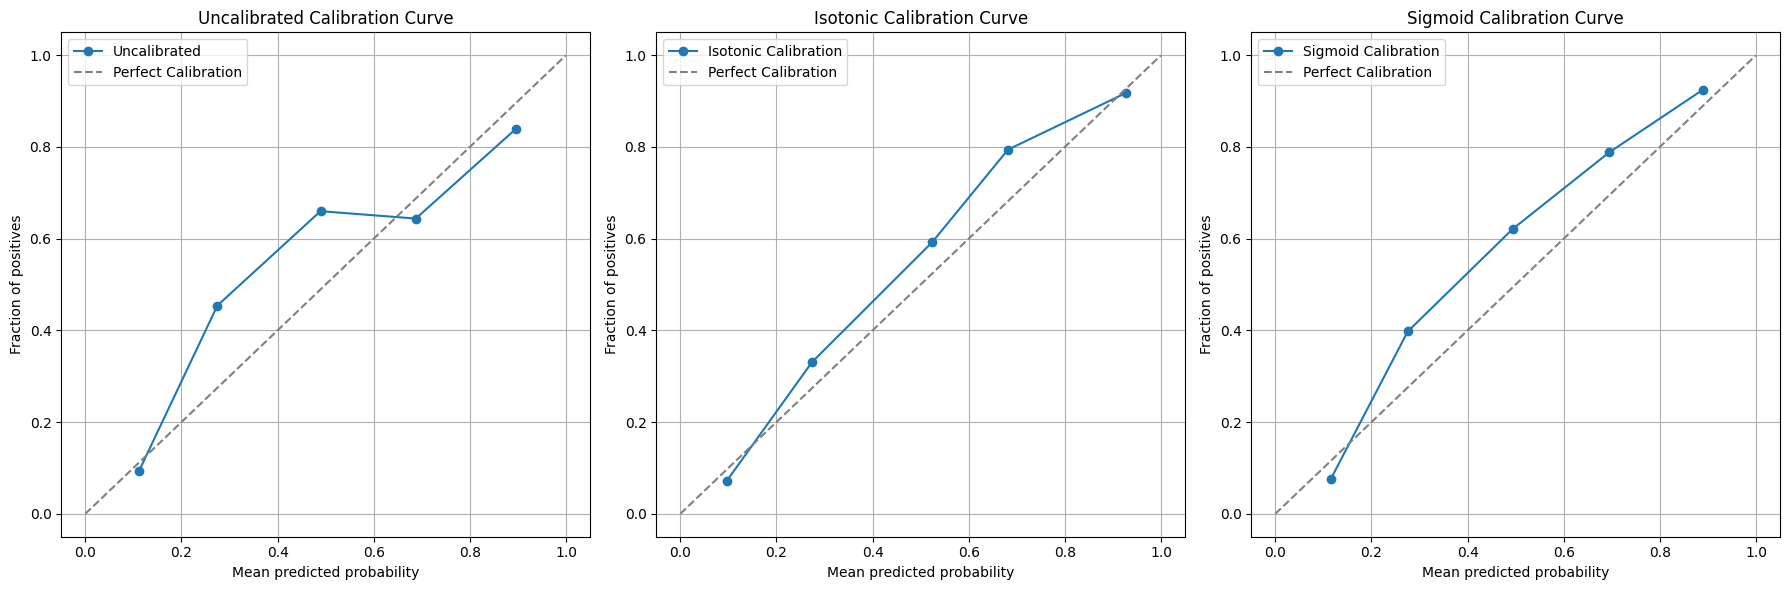

In [16]:
# Create three separate plots for each calibration method
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot uncalibrated calibration curve
axes[0].plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='o', label='Uncalibrated')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[0].set_xlabel('Mean predicted probability')
axes[0].set_ylabel('Fraction of positives')
axes[0].set_title('Uncalibrated Calibration Curve')
axes[0].legend()
axes[0].grid(True)

# Plot calibration curve for isotonic calibration
axes[1].plot(prob_pred_isotonic, prob_true_isotonic, marker='o', label='Isotonic Calibration')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[1].set_xlabel('Mean predicted probability')
axes[1].set_ylabel('Fraction of positives')
axes[1].set_title('Isotonic Calibration Curve')
axes[1].legend()
axes[1].grid(True)

# Plot calibration curve for sigmoid calibration
axes[2].plot(prob_pred_sigmoid, prob_true_sigmoid, marker='o', label='Sigmoid Calibration')
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[2].set_xlabel('Mean predicted probability')
axes[2].set_ylabel('Fraction of positives')
axes[2].set_title('Sigmoid Calibration Curve')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Model metrics measurement

Uncalibrated model classification report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1574
           1       0.73      0.33      0.45       426

    accuracy                           0.83      2000
   macro avg       0.78      0.65      0.68      2000
weighted avg       0.82      0.83      0.80      2000



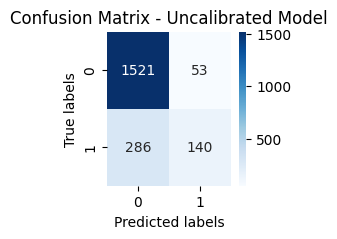

Sigmoid calibrated model classification report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1574
           1       0.80      0.40      0.53       426

    accuracy                           0.85      2000
   macro avg       0.83      0.69      0.72      2000
weighted avg       0.84      0.85      0.83      2000



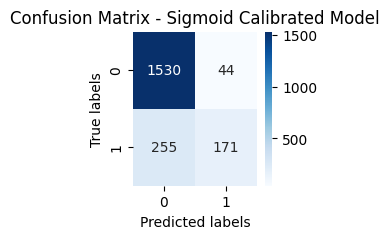

Isotonic calibrated model classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1574
           1       0.76      0.50      0.60       426

    accuracy                           0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



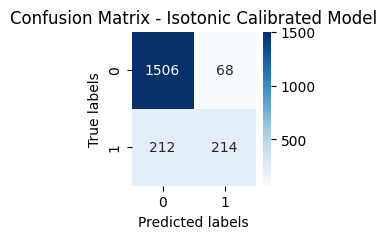

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Evaluate uncalibrated model
y_pred_val_uncalibrated = (prob_pos_val > 0.5).astype(int)
cm_uncalibrated = confusion_matrix(y_val, y_pred_val_uncalibrated)
print("Uncalibrated model classification report:")
print(classification_report(y_val, y_pred_val_uncalibrated))
plot_confusion_matrix(cm_uncalibrated, title="Confusion Matrix - Uncalibrated Model")

# Evaluate sigmoid calibrated model
y_pred_val_sigmoid = (prob_pos_val_sigmoid > 0.5).astype(int)
cm_sigmoid = confusion_matrix(y_val, y_pred_val_sigmoid)
print("Sigmoid calibrated model classification report:")
print(classification_report(y_val, y_pred_val_sigmoid))
plot_confusion_matrix(cm_sigmoid, title="Confusion Matrix - Sigmoid Calibrated Model")

# Evaluate isotonic calibrated model
y_pred_val_isotonic = (prob_pos_val_isotonic > 0.5).astype(int)
cm_isotonic = confusion_matrix(y_val, y_pred_val_isotonic)
print("Isotonic calibrated model classification report:")
print(classification_report(y_val, y_pred_val_isotonic))
plot_confusion_matrix(cm_isotonic, title="Confusion Matrix - Isotonic Calibrated Model")


### Key observations
* There is improvement in the model’s accuracy 0.83 < 0.85 < 0.86
* It is important to note that precision has improved 0.84 < 0.86 < 0.88
* The ROC curve also indicates isotonic and Sigmoid are very close and better than Uncalibrated model.

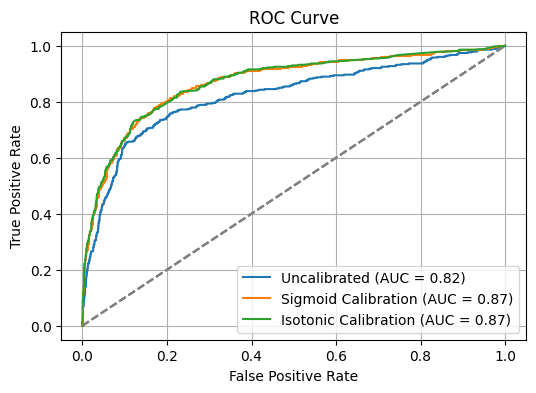

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# Define function to plot ROC curve
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

# Compute ROC curve and ROC AUC score for uncalibrated model
fpr_uncalibrated, tpr_uncalibrated, _ = roc_curve(y_val, prob_pos_val)
roc_auc_uncalibrated = roc_auc_score(y_val, prob_pos_val)

# Compute ROC curve and ROC AUC score for sigmoid calibrated model
fpr_sigmoid, tpr_sigmoid, _ = roc_curve(y_val, prob_pos_val_sigmoid)
roc_auc_sigmoid = roc_auc_score(y_val, prob_pos_val_sigmoid)

# Compute ROC curve and ROC AUC score for isotonic calibrated model
fpr_isotonic, tpr_isotonic, _ = roc_curve(y_val, prob_pos_val_isotonic)
roc_auc_isotonic = roc_auc_score(y_val, prob_pos_val_isotonic)

# Plot ROC curves
plt.figure(figsize=(6, 4))
plot_roc_curve(fpr_uncalibrated, tpr_uncalibrated, label=f'Uncalibrated (AUC = {roc_auc_uncalibrated:.2f})')
plot_roc_curve(fpr_sigmoid, tpr_sigmoid, label=f'Sigmoid Calibration (AUC = {roc_auc_sigmoid:.2f})')
plot_roc_curve(fpr_isotonic, tpr_isotonic, label=f'Isotonic Calibration (AUC = {roc_auc_isotonic:.2f})')
plt.legend()
plt.grid(True)
plt.show()

# The Brier score - Comparing Sogmoid and Isotonic models
#### As we observe the Sigmoid and Isotonic models are almost giving the same results. Let's see how similar they are using the Brier score.The Brier score is a metric used to assess the accuracy of probabilistic predictions in classification models. It measures the difference between predicted probabilities and actual outcomes, indicating the discrepancy between predicted probabilities and observed outcomes. Lower scores indicate better calibration, while higher scores indicate poorer calibration. The Brier score ranges from 0 to 1, with 0 indicating perfect calibration and 1 indicating complete miscalibration. It is commonly used to evaluate the calibration performance of binary and multi-class classification models.

In [17]:
from sklearn.metrics import brier_score_loss

# Calculate Brier score for sigmoid calibration
brier_score_sigmoid = brier_score_loss(y_val, prob_pos_val_sigmoid)

# Calculate Brier score for isotonic calibration
brier_score_isotonic = brier_score_loss(y_val, prob_pos_val_isotonic)

print("Brier Score (Sigmoid Calibration):", brier_score_sigmoid)
print("Brier Score (Isotonic Calibration):", brier_score_isotonic)


Brier Score (Sigmoid Calibration): 0.10885411896674385
Brier Score (Isotonic Calibration): 0.10447999956877632


# Conclusion
#### Probability calibration plays a vital role in machine learning, improving prediction accuracy and instilling greater confidence in model results. By aligning predicted probabilities with actual likelihoods, it empowers decision-makers with trustworthy estimates of uncertainty. Both sigmoid and isotonic calibration techniques offer efficiency and adaptability, fostering a deeper comprehension of models and facilitating more precise decision-making processes.